# 3. 합성곱 신경망을 이용한 이미지 분류

## 3.1 합성곱 신경망

텐서플로 임포트하기

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

MNIST 데이터셋 다운로드하고 준비하기

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# 픽셀 값을 0~1 사이로 정규화합니다.
train_images, test_images = train_images / 255.0, test_images / 255.0

합성곱 층 만들기

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) # (3,3,1,32) + (32,) = 320
model.add(layers.MaxPooling2D((2, 2)))  # (?,13,13,32)
model.add(layers.Conv2D(64, (3, 3), activation='relu')) # (3,3,32,64) + (64,) = 18496
model.add(layers.MaxPooling2D((2, 2)))  # (?,5,5,64)
model.add(layers.Conv2D(64, (3, 3), activation='relu')) # (3,3,64,64) + (64,) = 36928

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


마지막에 Dense 층 추가하기

In [5]:
model.add(layers.Flatten())  # (?,576)
model.add(layers.Dense(64, activation='relu'))  #(?,576) (576,64) + (64,) -> 36928
model.add(layers.Dense(10, activation='softmax')) # (?,64)(64,10) + (10,) -> 650

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

모델 컴파일과 훈련하기

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 10s 3ms/step - loss: 0.3252 - accuracy: 0.9005
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0491 - accuracy: 0.9841
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0339 - accuracy: 0.9892
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0236 - accuracy: 0.9922
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0162 - accuracy: 0.9949


모델 평가

In [8]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.0292 - accuracy: 0.9914


In [9]:
print(test_acc)

0.9914000034332275


## 3.2 이미지 분류

TensorFlow 및 기타 라이브러리 가져오기

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

데이터세트 다운로드 및 탐색하기

In [11]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

다운로드 후, 데이터세트 사본을 사용할 수 있습니다.

In [12]:
# print(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


다음은 몇 가지 장미입니다.

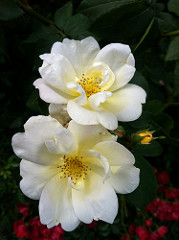

In [13]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

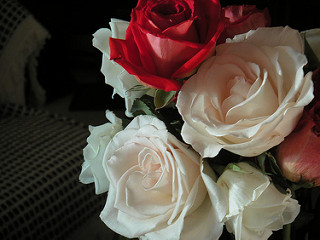

In [14]:
PIL.Image.open(str(roses[1]))

그리고 일부 튤립이 있습니다.

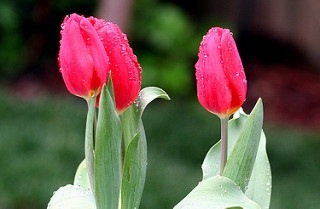

In [15]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

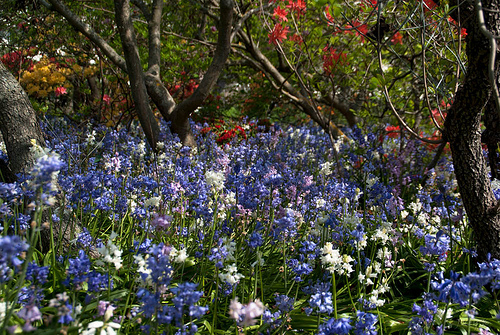

In [16]:
PIL.Image.open(str(tulips[1]))

### keras.preprocessing을 사용하여 로드하기

#### 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [17]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다.

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 class_names 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [20]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### 데이터 시각화하기

훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

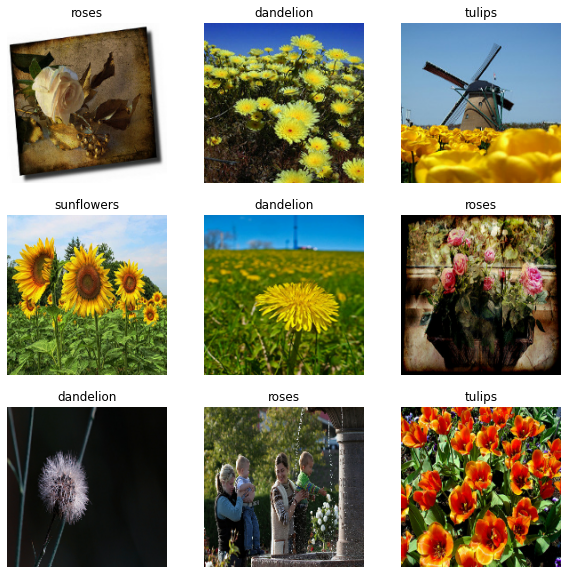

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

잠시 후에 이들 데이터세트를 model.fit에 전달하여 모델을 훈련하겠습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [22]:
i=0
for image_batch, labels_batch in train_ds:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     print(labels_batch)
  print(i)
  i += 1
#     break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


#### 성능을 높이도록 데이터세트 구성하기

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


#### 데이터 표준화하기

In [24]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9993465


#### 모델 만들기

In [26]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 모델 컴파일하기

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

모델의 summary 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)       

#### 모델 훈련하기

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 3s 32ms/step - loss: 1.5409 - accuracy: 0.3705 - val_loss: 1.0240 - val_accuracy: 0.6022
Epoch 2/10
92/92 [==============================] - 1s 8ms/step - loss: 1.0030 - accuracy: 0.6036 - val_loss: 0.9282 - val_accuracy: 0.6322
Epoch 3/10
92/92 [==============================] - 1s 8ms/step - loss: 0.7835 - accuracy: 0.7130 - val_loss: 0.9486 - val_accuracy: 0.6253
Epoch 4/10
92/92 [==============================] - 1s 8ms/step - loss: 0.5780 - accuracy: 0.7821 - val_loss: 0.9270 - val_accuracy: 0.6621
Epoch 5/10
92/92 [==============================] - 1s 8ms/step - loss: 0.3864 - accuracy: 0.8624 - val_loss: 0.9857 - val_accuracy: 0.6444
Epoch 6/10
92/92 [==============================] - 1s 8ms/step - loss: 0.2261 - accuracy: 0.9255 - val_loss: 1.4332 - val_accuracy: 0.6281
Epoch 7/10
92/92 [==============================] - 1s 8ms/step - loss: 0.1175 - accuracy: 0.9658 - val_loss: 1.4538 - val_accuracy: 0.6526
Epoch 8/10
92/92 [=

#### 훈련 결과 시각화하기

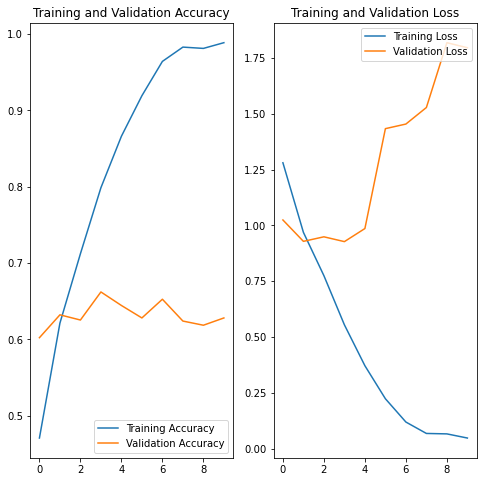

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 데이터 증강  목요일 수업예정

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### 데이터 증강 시각화 

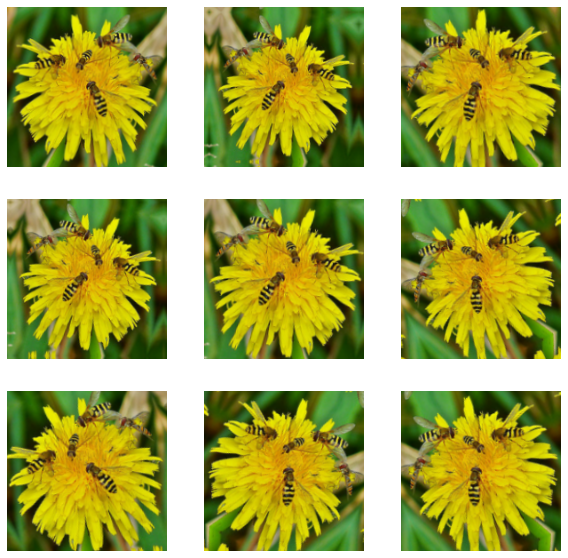

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### 드롭아웃

In [58]:
x = np.arange(1,21).reshape(5,4)

mask = np.random.rand(5,4)
mask = mask > 0.2
out = mask * x
print(out)

[[ 0  2  0  4]
 [ 5  6  7  0]
 [ 9 10 11 12]
 [ 0 14 15 16]
 [17  0 19 20]]


In [59]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 모델 컴파일 및 훈련하기

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

#### 훈련 결과 시각화하기

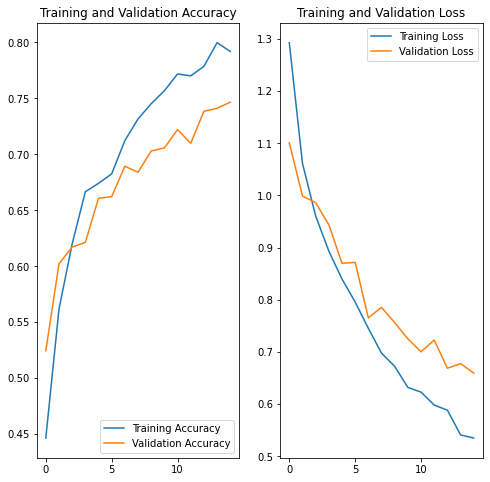

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 새로운 데이터로 예측하기

In [113]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [114]:
x = np.array([[1,2,3,4,5]])
out = softmax(x)
print(out)
print(np.sum(out))

[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]
1.0


In [78]:
x = np.array([[1,2,3,-4,-5]])
out = softmax(x)
print(out)
print(np.sum(out))

[[8.99559291e-02 2.44525567e-01 6.64689407e-01 6.06118283e-04
  2.22978455e-04]]
1.0


In [97]:
def softmax(x):
    if x.ndim == 2:
        #x = x.T
        #x = x - np.max(x, axis=0)
        temp = np.sum(np.exp(x), axis=1)
        print(temp)
        temp = temp.reshape(-1,1)
        print(temp)
        y = np.exp(x) / temp
        return y 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [98]:
x = np.array([[1,2,3,4,5],
              [5,4,3,2,1]])
out = softmax(x)
print(out)

[233.20418399 233.20418399]
[[233.20418399]
 [233.20418399]]
[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
 [0.63640865 0.23412166 0.08612854 0.03168492 0.01165623]]


In [107]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [108]:
np.exp(1000)

<ipython-input-108-47a6eab891c2>:1: RuntimeWarning: overflow encountered in exp
  np.exp(1000)


inf

In [109]:
x = np.array([[1000,1001,1002,1003,1004]])
out = softmax(x)
print(out)
print(np.sum(out))

[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]
1.0


In [116]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# print(sunflower_path)
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
# print(img)
img_array = keras.preprocessing.image.img_to_array(img)
# print(type(img_array))
# print(img_array.shape)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# temp = tf.constant(img_array)
# print(type(temp))
# print(type(img_array))
# print(img_array.shape)
predictions = model.predict(img_array)
print(type(predictions))
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

<class 'numpy.ndarray'>
[[-5.4772043  -3.3916311  -0.01704425  4.4202204   2.295116  ]]
tf.Tensor([4.4449836e-05 3.5778582e-04 1.0451717e-02 8.8362318e-01 1.0552272e-01], shape=(5,), dtype=float32)
This image most likely belongs to sunflowers with a 88.36 percent confidence.


## 3.3 전이학습 및 미세조정

### 사전 학습된 ConvNet을 이용한 전이 학습

In [117]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

keras = tf.keras

#### 데이터 다운로드

In [ ]:
!pip install tensorflow_datasets

In [120]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [122]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [123]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


cat


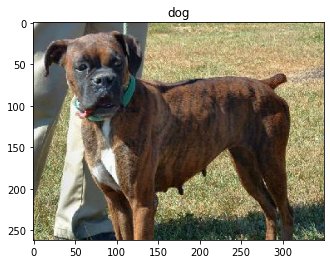

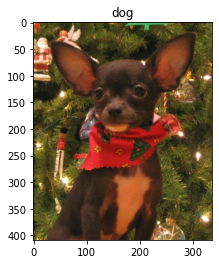

In [136]:
get_label_name = metadata.features['label'].int2str
print(get_label_name(0))
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

#### 데이터 포맷

In [140]:
IMG_SIZE = 160 # 모든 이미지는 160x160으로 크기가 조정됩니다

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1  # -1 ~ 1 사이의 값으로 리스케일링
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

map 함수를 사용하여 데이터셋의 각 항목에 이 함수를 적용하세요:

In [141]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

이제 데이터를 섞고 일괄 처리하세요.

In [142]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [143]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [145]:
for image_batch, label_batch in train_batches.take(1):
   pass
image_batch.shape

TensorShape([32, 160, 160, 3])

### 사전 훈련된 컨볼루션 네트워크로부터 기본 모델 생성하기

Google에서 개발한 MobileNet V2 모델로부터 기본 모델을 생성합니다.

In [151]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

이 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환합니다. 이미지 배치 예제에서 수행하는 작업을 확인하세요:

In [152]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### 컨볼루션 베이스 모델 고정하기

In [155]:
base_model.trainable = False

# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

#### 분류 층을 맨 위에 추가하기

In [163]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [164]:
x = np.arange(1,26).reshape(1,5,5,1)
x = tf.constant(x)
temp = global_average_layer(x)
print(temp.shape)
print(temp)

(1, 1)
tf.Tensor([[13]], shape=(1, 1), dtype=int32)


In [165]:
prediction_layer = keras.layers.Dense(1)  # (32,1280)(1280,1)+(1,) => (32,1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


이제 tf.keras.Sequential모델을 사용하여 특징 추출기와 이 두 층을 쌓으세요:

In [166]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### 모델 컴파일

In [168]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [171]:
model.trainable_variables

[<tf.Variable 'dense_6/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[ 0.04052692],
        [-0.0049143 ],
        [ 0.04527852],
        ...,
        [ 0.01479837],
        [-0.04268517],
        [ 0.05735944]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [172]:
len(model.trainable_variables)

2

#### 모델 훈련

In [173]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 30ms/step - loss: 0.7915 - accuracy: 0.4663


initial loss: 0.82
initial accuracy: 0.52

In [174]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 30s 48ms/step - loss: 0.2221 - accuracy: 0.8962 - val_loss: 0.0935 - val_accuracy: 0.9678
Epoch 2/10
582/582 [==============================] - 27s 46ms/step - loss: 0.0740 - accuracy: 0.9732 - val_loss: 0.0672 - val_accuracy: 0.9781
Epoch 3/10
582/582 [==============================] - 28s 46ms/step - loss: 0.0590 - accuracy: 0.9778 - val_loss: 0.0584 - val_accuracy: 0.9807
Epoch 4/10
582/582 [==============================] - 28s 47ms/step - loss: 0.0527 - accuracy: 0.9802 - val_loss: 0.0541 - val_accuracy: 0.9815
Epoch 5/10
582/582 [==============================] - 28s 47ms/step - loss: 0.0491 - accuracy: 0.9814 - val_loss: 0.0514 - val_accuracy: 0.9815
Epoch 6/10
582/582 [==============================] - 28s 47ms/step - loss: 0.0467 - accuracy: 0.9821 - val_loss: 0.0498 - val_accuracy: 0.9828
Epoch 7/10
582/582 [==============================] - 29s 48ms/step - loss: 0.0450 - accuracy: 0.9826 - val_loss: 0.0487 - val_accuracy:

#### 학습 곡선

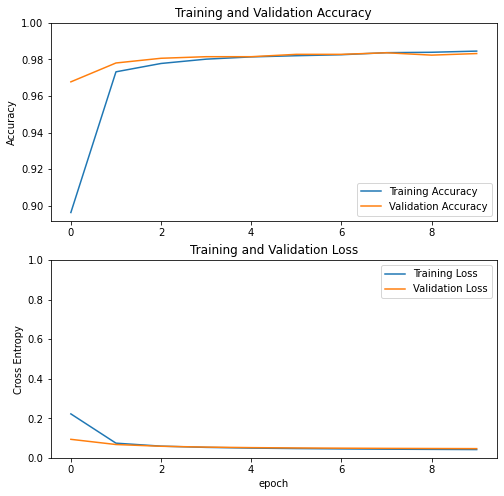

In [175]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 미세 조정

#### 최상위 층 고정 해제하기

In [177]:
base_model.trainable = True

# 기본 모델에 몇 개의 층이 있는지 확인 합니다.
print("Number of layers in the base model: ", len(base_model.layers))

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


#### 모델 컴파일

In [178]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [179]:
len(model.trainable_variables)

56

#### 모델 훈련 계속하기

In [180]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 45s 72ms/step - loss: 0.2074 - accuracy: 0.9249 - val_loss: 0.0601 - val_accuracy: 0.9824
Epoch 11/20
582/582 [==============================] - 41s 69ms/step - loss: 0.0689 - accuracy: 0.9717 - val_loss: 0.0505 - val_accuracy: 0.9828
Epoch 12/20
582/582 [==============================] - 45s 76ms/step - loss: 0.0571 - accuracy: 0.9787 - val_loss: 0.0504 - val_accuracy: 0.9815
Epoch 13/20
582/582 [==============================] - 47s 79ms/step - loss: 0.0427 - accuracy: 0.9829 - val_loss: 0.0492 - val_accuracy: 0.9811
Epoch 14/20
582/582 [==============================] - 45s 76ms/step - loss: 0.0304 - accuracy: 0.9882 - val_loss: 0.0511 - val_accuracy: 0.9819
Epoch 15/20
582/582 [==============================] - 48s 81ms/step - loss: 0.0228 - accuracy: 0.9923 - val_loss: 0.0505 - val_accuracy: 0.9841
Epoch 16/20
582/582 [==============================] - 48s 81ms/step - loss: 0.0208 - accuracy: 0.9915 - val_loss: 0.0533 - val_ac

In [181]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

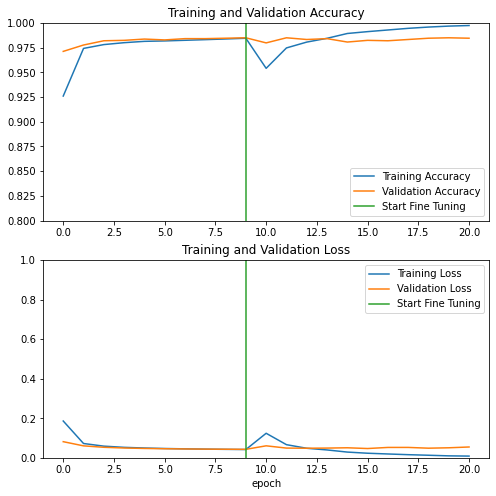

In [65]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 3.4 TF Hub를 사용한 전이 학습

In [182]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

#### 분류기 다운로드하기

In [183]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [185]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

#### 싱글 이미지 실행시키기

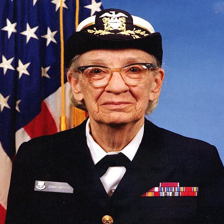

In [196]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [197]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

차원 배치를 추가하세요, 그리고 이미지를 모델에 통과시키세요.

In [198]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

그 결과는 로지트의 1001 요소 벡터입니다. 이는 이미지에 대한 각각의 클래스 확률을 계산합니다.
그래서 탑 클래스인 ID는 최대값을 알 수 있습니다:

In [199]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

#### 예측 해독하기

우리는 클래스 ID를 예측하고, ImageNet라벨을 불러오고, 그리고 예측을 해독합니다.

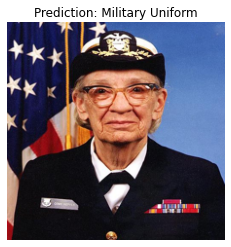

In [200]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [201]:
imagenet_labels[:100]

array(['background', 'tench', 'goldfish', 'great white shark',
       'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock',
       'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco',
       'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee',
       'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl',
       'European fire salamander', 'common newt', 'eft',
       'spotted salamander', 'axolotl', 'bullfrog', 'tree frog',
       'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle',
       'terrapin', 'box turtle', 'banded gecko', 'common iguana',
       'American chameleon', 'whiptail', 'agama', 'frilled lizard',
       'alligator lizard', 'Gila monster', 'green lizard',
       'African chameleon', 'Komodo dragon', 'African crocodile',
       'American alligator', 'triceratops', 'thunder snake',
       'ringneck snake', 'hognose snake', 'green snake', 'king snake',
       'garter snake', 'water snake', 'vine snake', 'night

#### 데이터셋

In [202]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)

In [203]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [204]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


#### 이미지 배치에 대한 분류기를 실행해보자

이제 이미지 배치에 대한 분류기를 실행해봅시다.

In [205]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [206]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['maze', 'worm fence', 'damselfly', 'picket fence', 'daisy',
       'rapeseed', 'spider web', 'daisy', 'daisy', 'daisy',
       'picket fence', 'garden spider', "yellow lady's slipper",
       'spider web', 'coral fungus', 'rapeseed', 'daisy', 'daisy',
       'quilt', 'rapeseed', 'Bedlington terrier', 'daisy',
       'cabbage butterfly', 'daisy', 'cardoon', 'coral fungus', 'daisy',
       'daisy', 'candle', 'paddlewheel', 'hummingbird', 'microwave'],
      dtype='<U30')

얼마나 많은 예측들이 이미지에 맞는지 검토해봅시다:

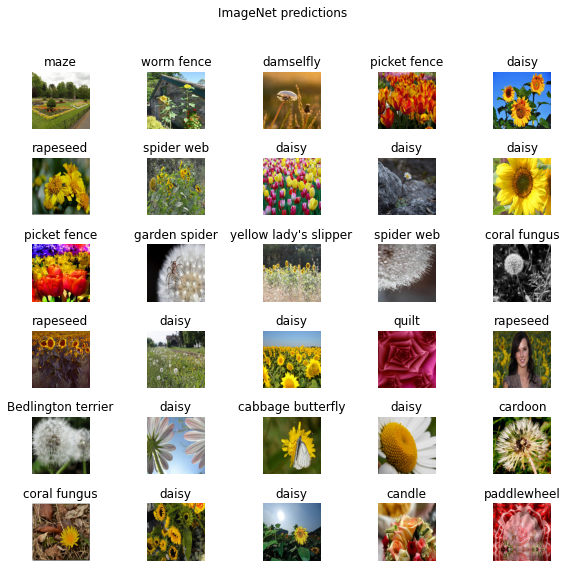

In [207]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

#### 헤드리스 모델을 다운로드하세요

In [210]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

특성 추출기를 만들어봅시다.

In [211]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

이 것은 각각의 이미지마다 길이가 1280인 벡터가 반환됩니다:

In [213]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


특성 추출기 계층에 있는 변수들을 굳히면, 학습은 오직 새로운 분류 계층만 변경시킬 수 있습니다.

In [214]:
feature_extractor_layer.trainable = False

#### 분류 head를 붙이세요.

이제 tf.keras.Sequential 모델에 있는 허브 계층을 포장하고, 새로운 분류 계층을 추가하세요.

In [215]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [216]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

#### 모델 학습

In [217]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [218]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [219]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

C:\Users\jikim\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
115/115 [==============================] - 10s 69ms/step - loss: 0.6547 - acc: 0.7692
Epoch 2/2
115/115 [==============================] - 8s 68ms/step - loss: 0.3349 - acc: 0.8842


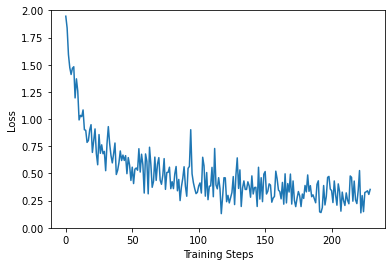

In [220]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

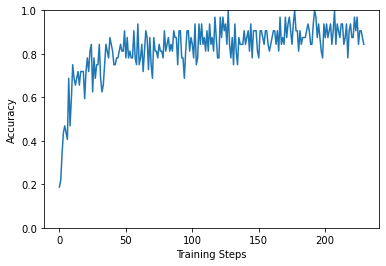

In [221]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

#### 예측 확인

In [223]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
print(class_names)
class_names = np.array([key.title() for key, value in class_names])
class_names

[('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)]


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [228]:
predicted_batch = model.predict(image_batch)
# predicted_batch.shape
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['Tulips' 'Sunflowers' 'Dandelion' 'Tulips' 'Sunflowers' 'Sunflowers'
 'Sunflowers' 'Tulips' 'Daisy' 'Sunflowers' 'Tulips' 'Dandelion'
 'Sunflowers' 'Dandelion' 'Dandelion' 'Sunflowers' 'Dandelion'
 'Sunflowers' 'Roses' 'Sunflowers' 'Dandelion' 'Daisy' 'Dandelion' 'Daisy'
 'Dandelion' 'Dandelion' 'Sunflowers' 'Sunflowers' 'Roses' 'Roses'
 'Tulips' 'Sunflowers']


In [230]:
label_id = np.argmax(label_batch, axis=-1)

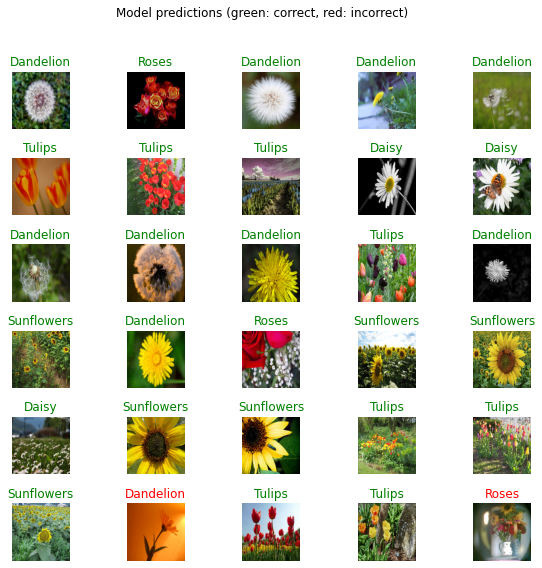

In [112]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#### 모델 저장 하기

In [231]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1631766410\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1631766410\assets


'/tmp/saved_models/1631766410'

#### 모델 로드 하기

In [232]:
reloaded = tf.keras.models.load_model(export_path)

In [233]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [234]:
abs(reloaded_result_batch - result_batch).max()

0.0

## 3.5 데이터 증강

In [235]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

#### 데이터세트 다운로드

In [236]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

꽃 데이터세트에는 5개의 클래스가 있습니다.

In [237]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색하고 이를 사용하여 데이터 증강을 수행하겠습니다.

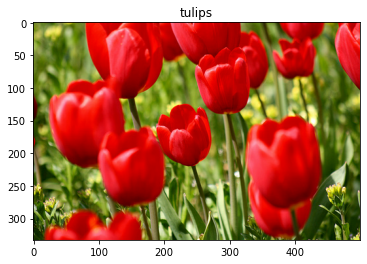

In [238]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

#### 크기 및 배율 조정하기

In [239]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

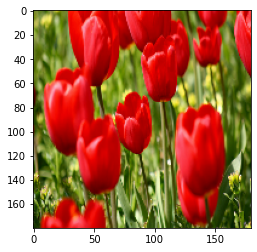

In [240]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [241]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


#### 데이터 증강

In [242]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [243]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

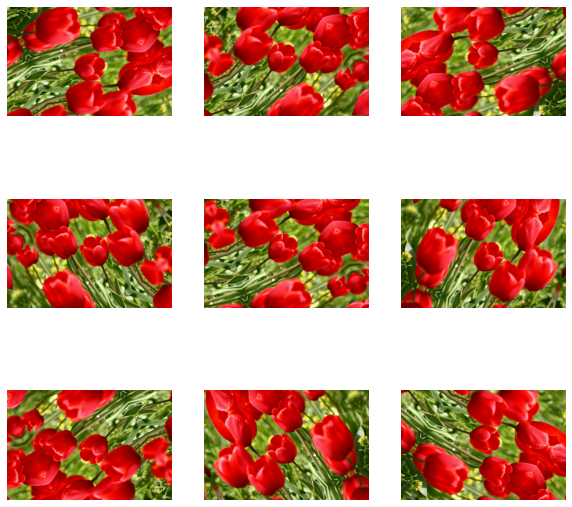

In [244]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

#### 전처리 레이어를 사용하는 두 가지 옵션

옵션 1: 전처리 레이어를 모델의 일부로 만들기

In [245]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

옵션 2: 데이터세트에 전처리 레이어 적용하기

In [246]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

#### 데이터세트에 전처리 레이어 적용하기

In [247]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [248]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

#### 모델 훈련하기

In [249]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [250]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [251]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 3s 21ms/step - loss: 1.4265 - accuracy: 0.3715 - val_loss: 1.1617 - val_accuracy: 0.5177
Epoch 2/5
92/92 [==============================] - 2s 16ms/step - loss: 1.1064 - accuracy: 0.5445 - val_loss: 1.0142 - val_accuracy: 0.6104
Epoch 3/5
92/92 [==============================] - 2s 16ms/step - loss: 0.9662 - accuracy: 0.6084 - val_loss: 1.0150 - val_accuracy: 0.6294
Epoch 4/5
92/92 [==============================] - 2s 16ms/step - loss: 0.9488 - accuracy: 0.6353 - val_loss: 0.9286 - val_accuracy: 0.6376
Epoch 5/5
92/92 [==============================] - 2s 16ms/step - loss: 0.8476 - accuracy: 0.6752 - val_loss: 0.8949 - val_accuracy: 0.6730


In [252]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 0s 5ms/step - loss: 0.8301 - accuracy: 0.6839
Accuracy 0.6839237213134766


#### 사용자 정의 데이터 증강

In [254]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [255]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

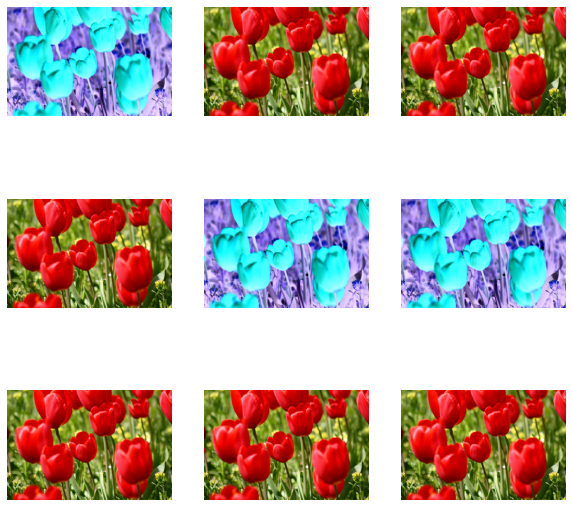

In [261]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

다음으로, 서브 클래스 생성을 통해 사용자 정의 레이어를 구현합니다.

In [280]:
class Base():
    def __call__(self):
        print("Base.__call__()")
        self.call()
        
    def call(self):
        print("Base.call()")

class Foo(Base):
    def __init__(self):
        print("Foo.__init__()")
    
    def call(self):
        print("Foo.call()")
        
foo = Foo()
foo()

Foo.__init__()
Base.__call__()
Foo.call()


In [283]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

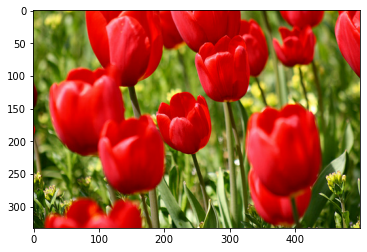

In [284]:
_ = plt.imshow(RandomInvert()(image)[0])

꽃 데이터세트는 이전에 데이터 증강으로 구성되었으므로 다시 가져와서 새로 시작하겠습니다.

In [285]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

작업할 이미지를 검색합니다.

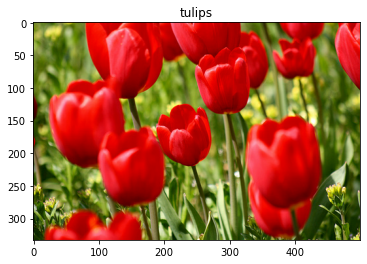

In [286]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

다음 함수를 사용하여 원본 이미지와 증강 이미지를 나란히 시각화하고 비교하겠습니다.

In [287]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

#### 이미지 뒤집기

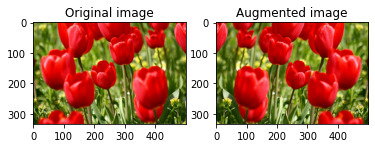

In [289]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### 이미지를 회색조로 만들기

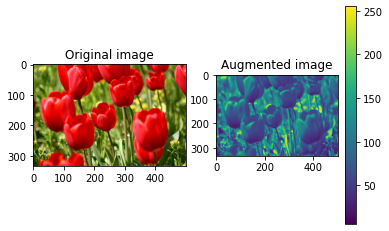

In [292]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### 이미지 포화시키기

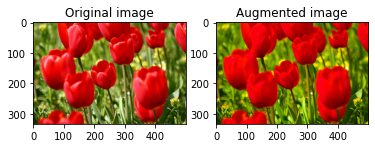

In [295]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### 이미지 밝기 변경하기

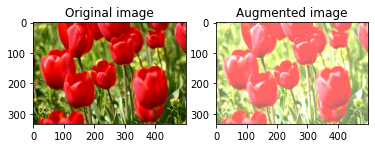

In [297]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### 이미지 중앙 자르기

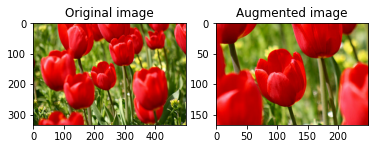

In [298]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

#### 이미지 회전하기

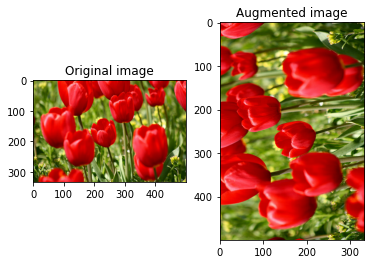

In [299]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### 데이터세트에 증강 적용하기

In [301]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [302]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### 데이터세트 구성하기

In [303]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [304]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [305]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

## 3.6 이미지 분절화

### 이미지 분할

- https://desktop.github.com/ 에서 windows용 git 설치
- git.exe 파일 path 설정
C:\Users\jikim\AppData\Local\GitHubDesktop\app-2.8.0\resources\app\git\cmd

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt

#### Oxford-IIIT Pets 데이터 세트를 다운로드 하기

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [5]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

데이터 세트에는 이미 필요한 몫의 시험과 훈련이 포함되어 있으므로 동일한 분할을 계속 사용합시다.

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

이미지 예제와 데이터 세트에서 대응하는 마스크를 보도록 합시다.

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

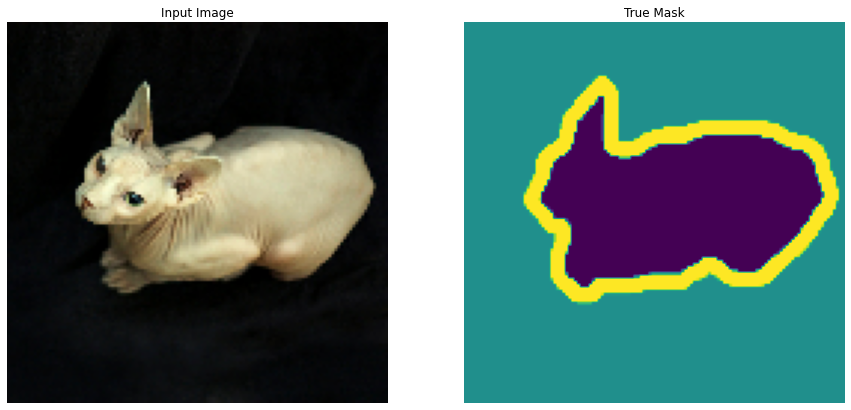

In [10]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

#### 모델 정의하기

In [11]:
OUTPUT_CHANNELS = 3

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

디코더/업샘플러는 TensorFlow 예제에서 구현된 일련의 업샘플 블록입니다.

In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#### 모델 훈련하기

In [15]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

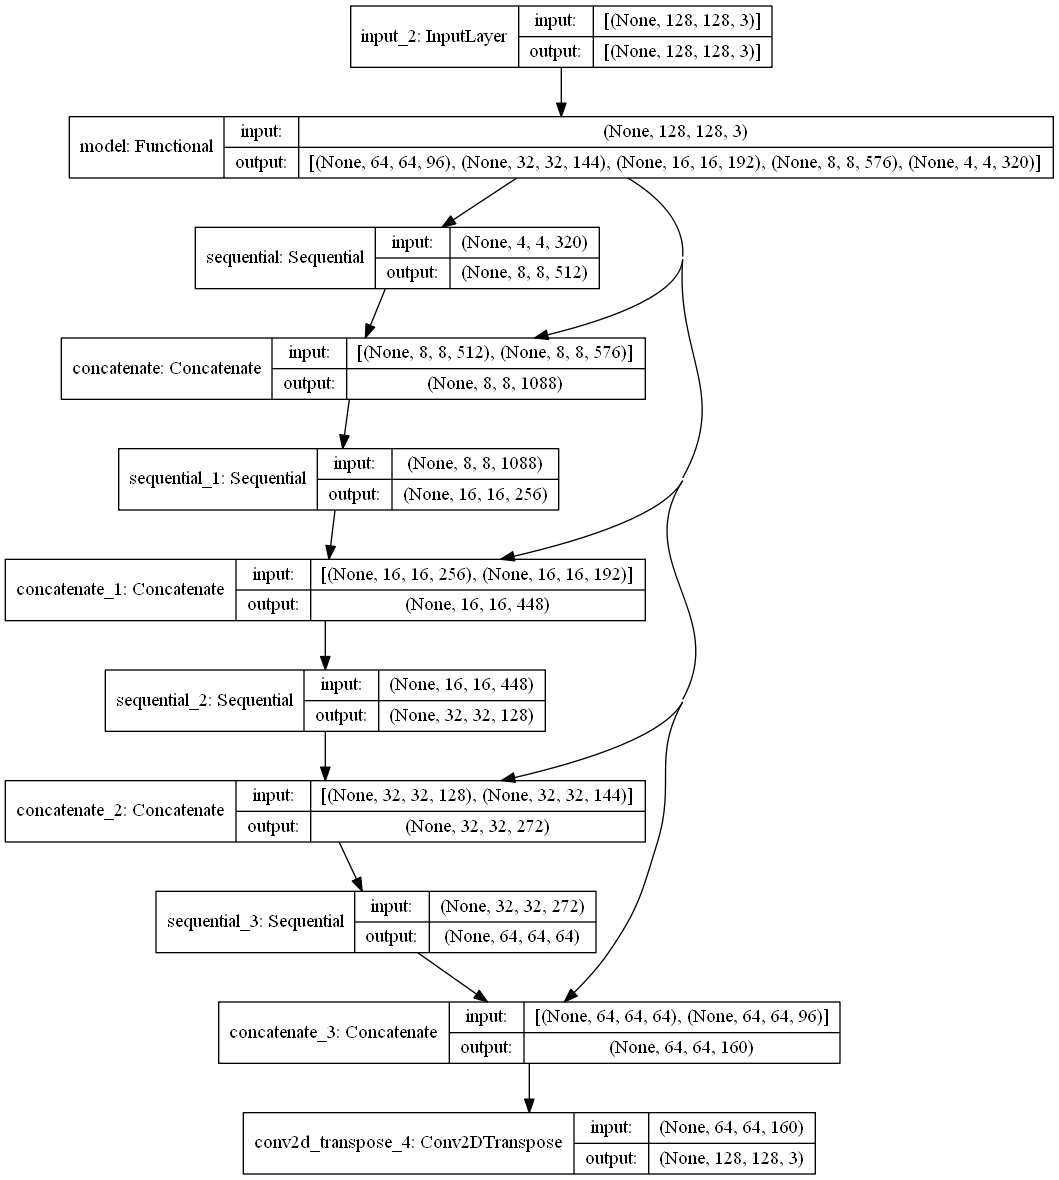

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

모델을 시험해보고 훈련 전에 예측한 것이 무엇인지 알아봅시다.

In [17]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

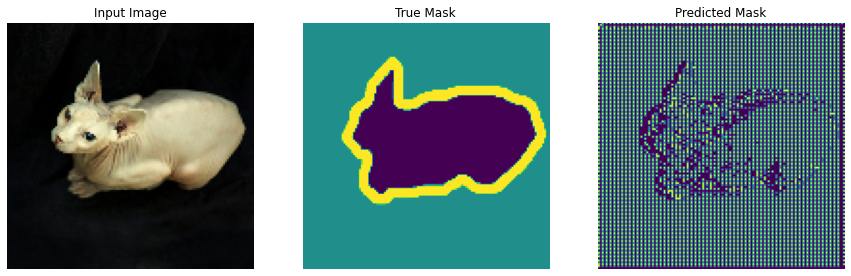

In [19]:
show_predictions()

모델이 훈련하는 동안 어떻게 향상되는지 관찰해 봅시다. 이 작업을 수행하기 위해 콜백 함수가 아래에 정의되어 있습니다.

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

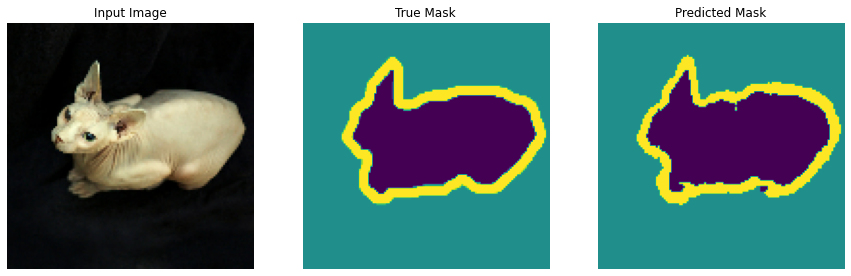


에포크 이후 예측 예시 20



In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

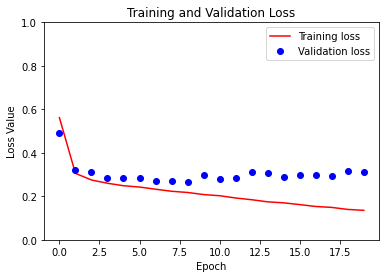

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#### 예측하기

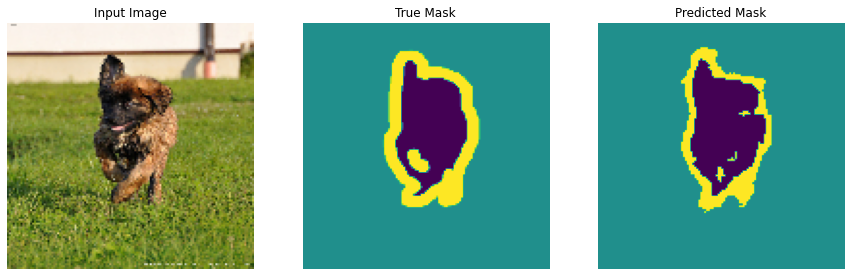

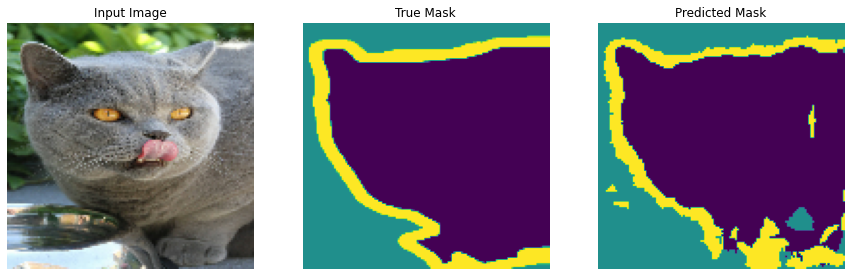

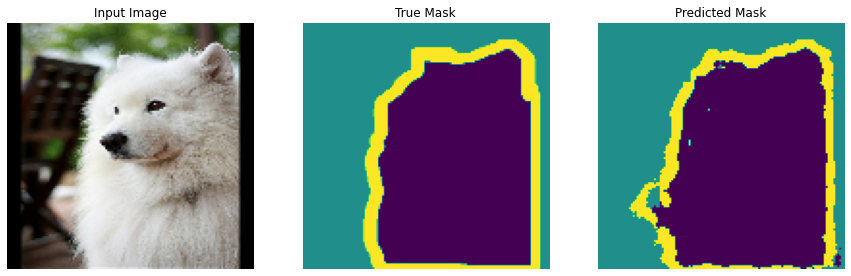

In [23]:
show_predictions(test_dataset, 3)